<html>
    <div style="background-color: lightskyblue; padding: 30px; color: black; text-align: center;">
    <h1>CAB420 - Assignment 2</h1>
    <h2>Building a DCNN Model to Classify Animals and Endangered Status</h2>
    </div>
</html>

Loading in the main modules for the project

In [66]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

Utility Functions

In [67]:
def load_images_from_folders(root_dir):
    # Root directory is 256_ObjectCategories

    print(f"Loading images from {root_dir}")
    image_paths = []
    # This is the main animals directory
    directories = os.listdir(root_dir)
    directories.sort()

    # This will have the animal directories
    for dirpath in directories:
        if dirpath != '.DS_Store':
            os.chdir(os.path.join(root_dir, dirpath))
            animal_images = os.listdir(os.getcwd())
            animal_images.sort()
            if animal_images[0] == '.DS_Store':
                # Remove the .DS_Store file if it exists
                animal_images.pop(0)
            print('Animal Images: ', animal_images)

            for i, image in enumerate(animal_images):
                if i < 81:
                    image_paths.append(os.path.join(os.getcwd(), image))
                else:
                    break

        os.chdir('..')
    return image_paths

def read_images(image_paths):
    images = []
    for image in image_paths:
        try:
            img = np.array(Image.open(image)) # or img = cv2.imread(path)
            images.append(img)
        except Exception as e:
             print(f"Error loading image: {image} - {e}")    
    return images

# Function used to evaluate the model
def eval_model(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

In [68]:
image_root = '/Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories'

image_paths = load_images_from_folders(image_root)
animal_images = read_images(image_paths)


Loading images from /Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/256_ObjectCategories
Animal Images:  ['009_0001.jpg', '009_0002.jpg', '009_0003.jpg', '009_0004.jpg', '009_0005.jpg', '009_0006.jpg', '009_0007.jpg', '009_0008.jpg', '009_0009.jpg', '009_0010.jpg', '009_0011.jpg', '009_0012.jpg', '009_0013.jpg', '009_0014.jpg', '009_0015.jpg', '009_0016.jpg', '009_0017.jpg', '009_0018.jpg', '009_0019.jpg', '009_0020.jpg', '009_0021.jpg', '009_0022.jpg', '009_0023.jpg', '009_0024.jpg', '009_0025.jpg', '009_0026.jpg', '009_0027.jpg', '009_0028.jpg', '009_0029.jpg', '009_0030.jpg', '009_0031.jpg', '009_0032.jpg', '009_0033.jpg', '009_0034.jpg', '009_0035.jpg', '009_0036.jpg', '009_0037.jpg', '009_0038.jpg', '009_0039.jpg', '009_0040.jpg', '009_0041.jpg', '009_0042.jpg', '009_0043.jpg', '009_0044.jpg', '009_0045.jpg', '009_0046.jpg', '009_0047.jpg', '009_0048.jpg', '009_0049.jpg', '009_0050.jpg', '009_0051.jpg', '009_0052.jpg', '009_0053.jpg', '009_0054.jpg', '009_

Downloading the datasets

In [69]:
labelled_data = pd.read_csv("/Users/aidanlockwood/GitHub/CAB420-Codebase/Assessment/assignment_2/data/labelled_data.csv")


In [70]:
len(animal_images)

2592

In [71]:
labelled_data.sort_values(by = 'filename_id', inplace = True)

These images aren't in a standardised format. Going to implement a resize to keep them in the same format

In [72]:
animal_np_images = []
unseen_np_images = []

for i in range(len(animal_images)):
    image_np = np.array(animal_images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    animal_np_images.append(image_np) 


animal_np_images = np.array(animal_np_images)


Organising the train/test split

In [73]:
len(labelled_data)

2592

In [74]:
sorted_list = sorted(labelled_data['filename_id'].to_list())

In [75]:
for i in range(len(sorted_list)):
    print({sorted_list[i] : image_paths[i][-12:]})

{'009_0001': '009_0001.jpg'}
{'009_0002': '009_0002.jpg'}
{'009_0003': '009_0003.jpg'}
{'009_0004': '009_0004.jpg'}
{'009_0005': '009_0005.jpg'}
{'009_0006': '009_0006.jpg'}
{'009_0007': '009_0007.jpg'}
{'009_0008': '009_0008.jpg'}
{'009_0009': '009_0009.jpg'}
{'009_0010': '009_0010.jpg'}
{'009_0011': '009_0011.jpg'}
{'009_0012': '009_0012.jpg'}
{'009_0013': '009_0013.jpg'}
{'009_0014': '009_0014.jpg'}
{'009_0015': '009_0015.jpg'}
{'009_0016': '009_0016.jpg'}
{'009_0017': '009_0017.jpg'}
{'009_0018': '009_0018.jpg'}
{'009_0019': '009_0019.jpg'}
{'009_0020': '009_0020.jpg'}
{'009_0021': '009_0021.jpg'}
{'009_0022': '009_0022.jpg'}
{'009_0023': '009_0023.jpg'}
{'009_0024': '009_0024.jpg'}
{'009_0025': '009_0025.jpg'}
{'009_0026': '009_0026.jpg'}
{'009_0027': '009_0027.jpg'}
{'009_0028': '009_0028.jpg'}
{'009_0029': '009_0029.jpg'}
{'009_0030': '009_0030.jpg'}
{'009_0031': '009_0031.jpg'}
{'009_0032': '009_0032.jpg'}
{'009_0033': '009_0033.jpg'}
{'009_0034': '009_0034.jpg'}
{'009_0035': '

In [76]:
# Labelled data
animal_train_X, animal_test_X, species_labelled_train_Y, species_labelled_test_Y = train_test_split(animal_np_images, labelled_data['species'], test_size=0.2, random_state=42)
species_labelled_train_Y = species_labelled_train_Y.reset_index(drop=True)


# Convert labels to one-hot encoding
species_labelled_train_Y = to_categorical(species_labelled_train_Y, num_classes = 32)
species_labelled_test_Y = to_categorical(species_labelled_test_Y, num_classes = 32)

Visualising the images found

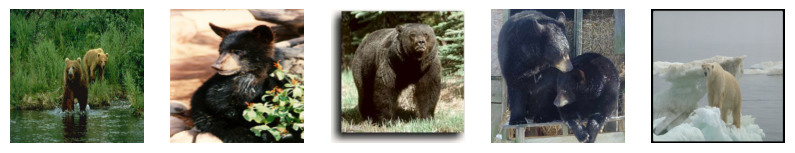

In [77]:
fig = plt.figure(figsize=(10, 10))

image_range = animal_np_images[0:5]

for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(1, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    except:
        break
plt.show()

### Time to Build the Network

Creating an augmentation layer

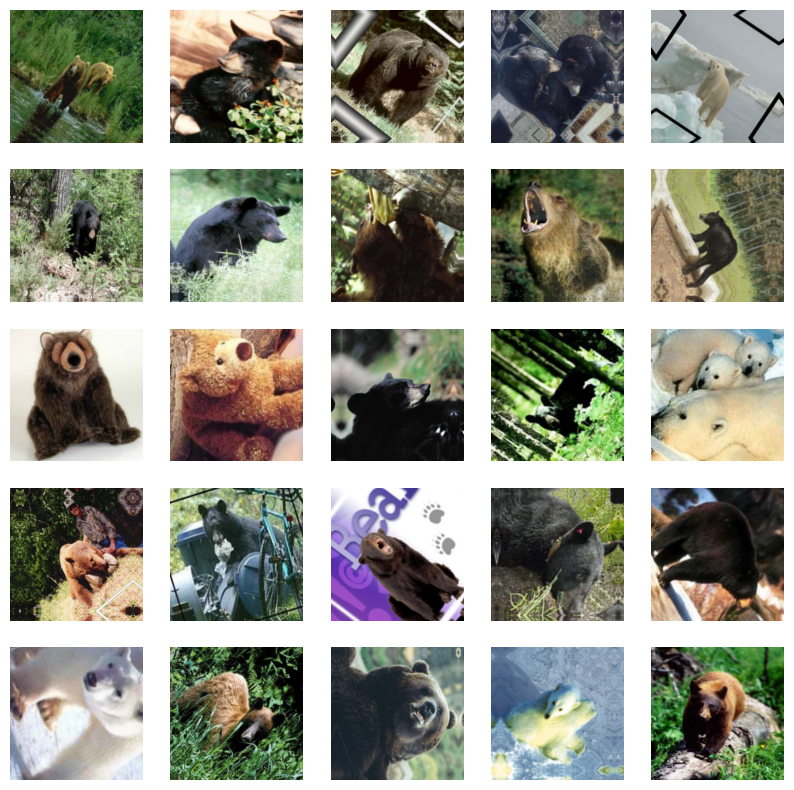

In [78]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

fig = plt.figure(figsize=(10, 10))
image_range = animal_np_images[0:50]
for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(5, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(data_augmentation(img))
        ax.axis('off')
    except:
        break

plt.show()

Doing some normalisation for model training

In [79]:
animal_train_X = animal_train_X.astype('float32') / 255.0
animal_test_X = animal_test_X.astype('float32') / 255.0

In [80]:
animal_train_X

array([[[[0.3372549 , 0.42745098, 0.41568628],
         [0.49803922, 0.4       , 0.37254903],
         [0.99215686, 1.        , 1.        ],
         ...,
         [0.3647059 , 0.36078432, 0.38039216],
         [0.36078432, 0.35686275, 0.38039216],
         [0.2627451 , 0.26666668, 0.2627451 ]],

        [[0.28627452, 0.36078432, 0.30980393],
         [0.49411765, 0.37254903, 0.32156864],
         [1.        , 0.99607843, 0.9882353 ],
         ...,
         [0.3137255 , 0.2784314 , 0.22745098],
         [0.4509804 , 0.41960785, 0.39607844],
         [0.34117648, 0.3137255 , 0.30588236]],

        [[0.29803923, 0.36078432, 0.3019608 ],
         [0.5019608 , 0.3529412 , 0.2901961 ],
         [0.99607843, 0.99215686, 0.99607843],
         ...,
         [0.38431373, 0.34509805, 0.27450982],
         [0.36078432, 0.32156864, 0.26666668],
         [0.38431373, 0.34901962, 0.32941177]],

        ...,

        [[0.6117647 , 0.61960787, 0.6509804 ],
         [0.67058825, 0.6862745 , 0.72156864]

In [ ]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    # First conv block
    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv block (optionally downsampling)
    if downsample:
        x = layers.Conv2D(filters, (3, 3), strides=2, padding='same', use_bias=False)(x)
    else:
        x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2 if downsample else 1),
                                 padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual addition
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_model():
    input_layer = layers.Input(shape=(256, 256, 3), name='input_image')

    x = layers.RandomFlip('horizontal')(input_layer)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomBrightness(0.2)(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.2)(x)
    x = layers.RandomContrast(0.2)(x)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation = 'relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    encoding_layer = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoding_layer)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded_layer = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(x)

    # Adding a classification head
    x_class = residual_block(encoding_layer, 32, downsample=True)
    x_class = residual_block(x_class, 32)
    x_class = residual_block(x_class, 32, downsample=True)
    x_class = residual_block(x_class, 32)
    x_class = layers.GlobalAveragePooling2D()(x_class)
    x_class = layers.Dense(64, activation='relu')(x_class)
    x_class = layers.Dense(32, activation='relu')(x_class)
    classification_output = layers.Dense(32, activation='softmax', name='classification_output')(x_class)

    model = keras.Model(inputs=input_layer, outputs=[decoded_layer, classification_output])

    return model

def train_model(model, train_X, train_Y_1, train_Y_2, test_X, test_Y_1, test_Y_2, epochs=10, batch_size=32):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', 'accuracy'],
        loss = ['mean_squared_error', 'categorical_crossentropy'],
        loss_weights = [0.1, 1.0],
        jit_compile=False
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience = 5,
        restore_best_weights=True
    )

    history = model.fit(
        train_X,
        [train_Y_1, train_Y_2],
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (test_X, [test_Y_1, test_Y_2]),
        callbacks = [early_stop],
        verbose = 1
    )
    
    return history

model = build_model()

model.summary()

from tensorflow.keras.utils import plot_model

# Assuming you've already built the model:
plot_model(model, to_file="resnet_custom_model.png", show_shapes=True, show_layer_names=True)

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_441 (Conv2D) │ (None, 256, 256,  │        448 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_104   │ (None, 128, 128,  │          0 │ conv2d_441[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_442 (Conv2D) │ (None, 128, 128,  │      1,160 │ max_pooling2d_10… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_105   │ (None, 64, 64, 8) │          0 │ conv2d_442[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck          │ (None, 32, 32, 8) │          0 │ max_pooling2d_10… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_446 (Conv2D) │ (None, 32, 32,    │      2,304 │ bottleneck[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_446[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_232      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_447 (Conv2D) │ (None, 16, 16,    │      9,216 │ activation_232[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_448 (Conv2D) │ (None, 16, 16,    │        256 │ bottleneck[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_447[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_448[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_101 (Add)       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_233      │ (None, 16, 16,    │          0 │ add_101[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_449 (Conv2D) │ (None, 16, 16,    │      9,216 │ activation_233[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_449[0][0]

 Total params: 79,003 (308.61 KB)

 Trainable params: 78,363 (306.11 KB)

 Non-trainable params: 640 (2.50 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Initial training

Trialling two residual blocks to see how performance changes

In [135]:
model_2 = build_model()
history_2 = train_model(model_2, animal_train_X, animal_train_X, species_labelled_train_Y, animal_test_X, animal_test_X, species_labelled_test_Y, epochs = 6, batch_size = 128)
# eval_model(model_2, animal_train_X, species_labelled_train_Y, animal_test_X, species_labelled_test_Y)

Epoch 1/6
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - classification_output_accuracy: 0.0374 - classification_output_loss: 3.4664 - decoded_output_accuracy: 0.4539 - decoded_output_loss: 0.0733 - loss: 3.4740 - val_classification_output_accuracy: 0.0270 - val_classification_output_loss: 163.1074 - val_decoded_output_accuracy: 0.4680 - val_decoded_output_loss: 0.0487 - val_loss: 163.5223
Epoch 2/6
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - classification_output_accuracy: 0.0817 - classification_output_loss: 3.3311 - decoded_output_accuracy: 0.4473 - decoded_output_loss: 0.0414 - loss: 3.3345 - val_classification_output_accuracy: 0.0366 - val_classification_output_loss: 90.8098 - val_decoded_output_accuracy: 0.4925 - val_decoded_output_loss: 0.0317 - val_loss: 91.1363
Epoch 3/6
17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - classification_output_accuracy: 0.0975 - classification_output_loss: 3.2182 - decoded_output_accuracy: 0.5083 - decoded_output_loss: 0.0293 - loss: 3.2212 - val_classification_o

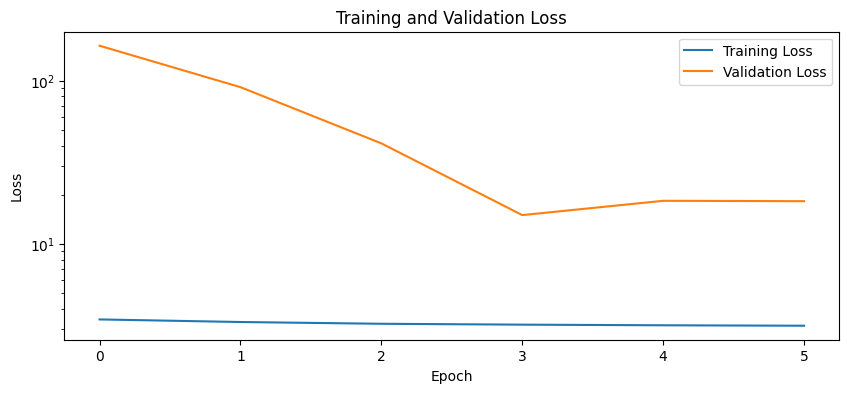

In [136]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history_2.history)